## Word Segmentation

## Importing

In [62]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Reading and resizing

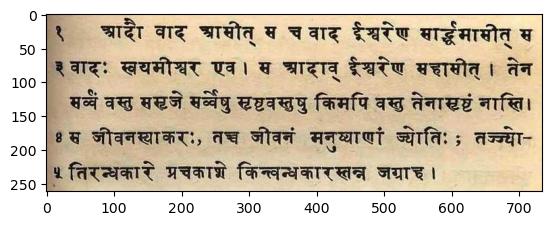

In [63]:
img = cv2.imread('A:\Projects\SanskritConversion\Sanskrit_Text_Conversion\images\sampleimage.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w, c = img.shape

if w > 1000:
    
    new_w = 1000
    ar = w/h
    new_h = int(new_w/ar)
    
    img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)
plt.imshow(img)

## Preprocessing

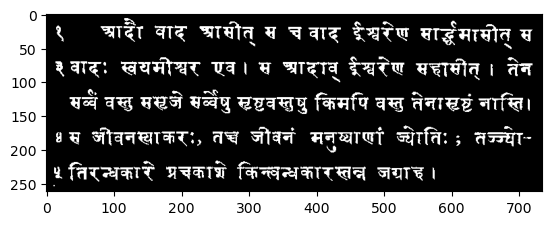

In [64]:
def thresholding(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray,80,255,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap='gray')
    return thresh

thresh_img = thresholding(img);

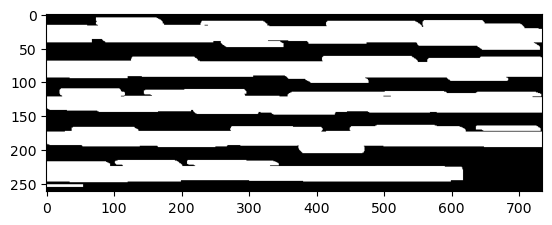

In [65]:
#dilation
kernel = np.ones((3,85), np.uint8)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated, cmap='gray');

In [66]:
(contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)

## Line segmentation

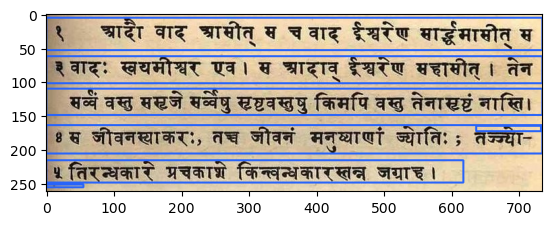

In [67]:
img2 = img.copy()

for ctr in sorted_contours_lines:
    
    x,y,w,h = cv2.boundingRect(ctr)
    cv2.rectangle(img2, (x,y), (x+w, y+h), (40, 100, 250), 2)
    
plt.imshow(img2);

## Text segmentation

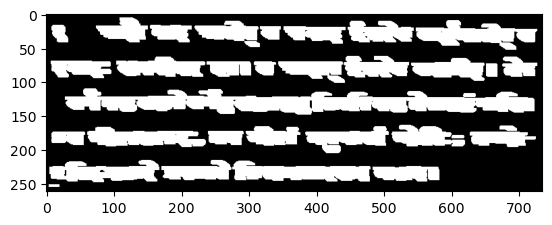

In [68]:
#dilation
kernel = np.ones((3,15), np.uint8)
dilated2 = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated2, cmap='gray');

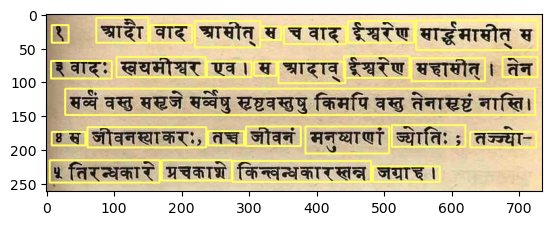

In [69]:
img3 = img.copy()
words_list = []

for line in sorted_contours_lines:
    
    # roi of each line
    x, y, w, h = cv2.boundingRect(line)
    roi_line = dilated2[y:y+h, x:x+w]
    
    # draw contours on each word
    (cnt, heirarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contour_words = sorted(cnt, key=lambda cntr : cv2.boundingRect(cntr)[0])
    
    for word in sorted_contour_words:
        
        if cv2.contourArea(word) < 400:
            continue
        
        x2, y2, w2, h2 = cv2.boundingRect(word)
        words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
        cv2.rectangle(img3, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (255,255,100),2)
        
plt.imshow(img3);

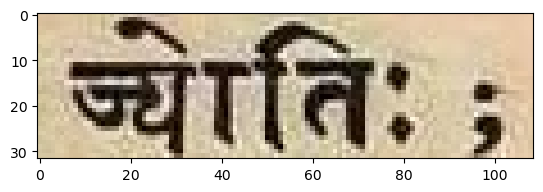

In [71]:
ninth_word = words_list[22]
roi_9 = img[ninth_word[1]:ninth_word[3], ninth_word[0]:ninth_word[2]]
plt.imshow(roi_9)

In [72]:
import cv2
import numpy as np
from os.path import join
#import pytesseract as ta
import matplotlib.pyplot as plt
import pandas as pd

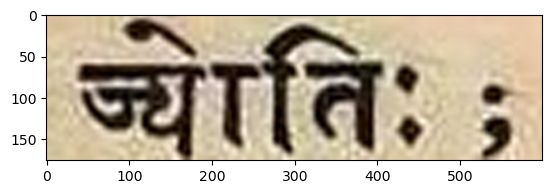

In [73]:
img = roi_9

#resizing
h, w, c = img.shape
ar = w/h
targetWidth = 600
targetHeight = int(targetWidth / ar)
img = cv2.resize(img, (targetWidth, targetHeight), interpolation=cv2.INTER_CUBIC)

plt.imshow(img);

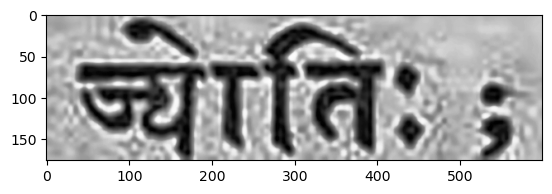

In [74]:
# blurring and splitting
img_blf = cv2.bilateralFilter(img, 5, 7,7)

lab = cv2.cvtColor(img_blf, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)

#clahe
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 4))
cl = clahe.apply(l)
limg = cv2.merge((cl, a, b))

# colour conversion
cimg = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
gray = cv2.cvtColor(cimg, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap='gray');

In [75]:
def check_bg_color(image):
    ''' Checks if background color is black or white '''
    check = cv2.threshold(image, 0,255, cv2.THRESH_OTSU)[1]
    print(check)
    u, c = np.unique(check, return_counts=True)
    d = dict(zip(u,c))
    print(d)
    srt = sorted(d.items(), key = lambda x : x[1], reverse = True)
    print(srt)
    return srt[0][0]

#checking color - if white then 255 else 0
bg_color = check_bg_color(gray)
print()
bg_color

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
{0: 27056, 255: 78544}
[(255, 78544), (0, 27056)]



255

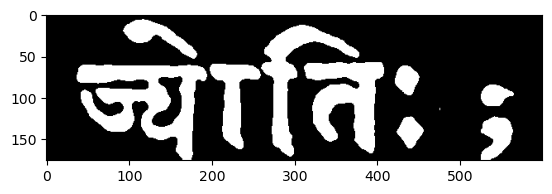

In [76]:
if bg_color == 255:
    ''' Performs preprocessing suitable for a white bg image '''
    ret4, final_img2 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    morp = cv2.morphologyEx(final_img2, cv2.MORPH_OPEN, (5,5))
    plt.imshow(morp, cmap='gray')
    
    
elif bg_color == 0:
    ''' Performs preprocessing suitable for a black bg image '''
    ret4, final_img2 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    morp = cv2.morphologyEx(final_img2, cv2.MORPH_OPEN, (5,5))
    plt.imshow(morp, cmap='gray')

In [77]:
im = morp.copy()
    
horizontal_hist = np.sum(im, axis=1, keepdims=True)/255
v=horizontal_hist.flatten()
v

array([  0.,   0.,   0.,   0.,   0.,   0.,   3.,  16.,  21.,  25.,  30.,
        34.,  40.,  52.,  62.,  74.,  81.,  87.,  93.,  98., 102., 107.,
       112., 116., 122., 121., 122., 123., 128., 131., 132., 133., 132.,
       126., 109.,  94.,  88.,  89.,  86.,  85.,  84.,  77.,  76.,  74.,
        73.,  72.,  70.,  67.,  62.,  54.,  47.,  37.,  28.,  21.,  18.,
        17.,  17.,  19.,  60., 110., 144., 207., 325., 346., 358., 364.,
       368., 369., 371., 375., 376., 376., 375., 375., 372., 364., 337.,
       311., 270., 223., 183., 156., 144., 112., 118., 143., 153., 162.,
       169., 192., 234., 257., 262., 268., 270., 271., 269., 269., 264.,
       258., 256., 256., 255., 252., 250., 237., 225., 208., 184., 175.,
       168., 150., 149., 149., 149., 151., 150., 149., 151., 151., 154.,
       155., 161., 170., 184., 198., 206., 207., 213., 217., 219., 222.,
       224., 227., 232., 242., 250., 249., 246., 247., 244., 236., 215.,
       211., 207., 206., 200., 195., 182., 171., 16

In [78]:
df = pd.DataFrame(v)
df = df.T
df

,0,1,2,3,4,5,6,7,8,9,...,166,167,168,169,170,171,172,173,174,175
0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,16.0,21.0,25.0,...,65.0,59.0,51.0,47.0,43.0,38.0,32.0,28.0,24.0,23.0


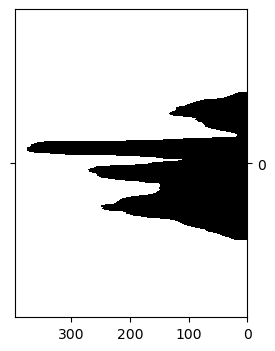

In [79]:
df.plot(kind='barh', color='k', legend=False, figsize=(3,4))
#plt.yticks.set_ticks_position("right")
plt.tick_params(axis='y', which='both', labelright=True, right=True, labelleft=False)
                                    #labelbottom = True, bottom = True, left=False

u = np.max(df.values) + 20
plt.xlim(u,0)
plt.gca().invert_yaxis()

plt.show()

In [80]:
ht = list(v)
print(len(ht))
half = len(ht)//2
print(half)

176
88


In [81]:
ht1 = ht[:half]
ht2 = ht[half:]

print(len(ht1))
print(len(ht2))

88
88


In [82]:
threshold = 40  # threshold for extreme pixels of numbers (start and end of dips)
offset = len(ht1)

In [83]:
print(ht1)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 16.0, 21.0, 25.0, 30.0, 34.0, 40.0, 52.0, 62.0, 74.0, 81.0, 87.0, 93.0, 98.0, 102.0, 107.0, 112.0, 116.0, 122.0, 121.0, 122.0, 123.0, 128.0, 131.0, 132.0, 133.0, 132.0, 126.0, 109.0, 94.0, 88.0, 89.0, 86.0, 85.0, 84.0, 77.0, 76.0, 74.0, 73.0, 72.0, 70.0, 67.0, 62.0, 54.0, 47.0, 37.0, 28.0, 21.0, 18.0, 17.0, 17.0, 19.0, 60.0, 110.0, 144.0, 207.0, 325.0, 346.0, 358.0, 364.0, 368.0, 369.0, 371.0, 375.0, 376.0, 376.0, 375.0, 375.0, 372.0, 364.0, 337.0, 311.0, 270.0, 223.0, 183.0, 156.0, 144.0, 112.0, 118.0, 143.0, 153.0, 162.0]


In [84]:
for i in range(len(ht1)-1, -1, -1):
    print(ht1[i])
    
    #checking if value is < 40 and stopping
    if ht1[i] < 40:
        print('break point', i)
        left_limit = i+1
        print(left_limit)
        break

162.0
153.0
143.0
118.0
112.0
144.0
156.0
183.0
223.0
270.0
311.0
337.0
364.0
372.0
375.0
375.0
376.0
376.0
375.0
371.0
369.0
368.0
364.0
358.0
346.0
325.0
207.0
144.0
110.0
60.0
19.0
break point 57
58


In [85]:
print(ht2)

[169.0, 192.0, 234.0, 257.0, 262.0, 268.0, 270.0, 271.0, 269.0, 269.0, 264.0, 258.0, 256.0, 256.0, 255.0, 252.0, 250.0, 237.0, 225.0, 208.0, 184.0, 175.0, 168.0, 150.0, 149.0, 149.0, 149.0, 151.0, 150.0, 149.0, 151.0, 151.0, 154.0, 155.0, 161.0, 170.0, 184.0, 198.0, 206.0, 207.0, 213.0, 217.0, 219.0, 222.0, 224.0, 227.0, 232.0, 242.0, 250.0, 249.0, 246.0, 247.0, 244.0, 236.0, 215.0, 211.0, 207.0, 206.0, 200.0, 195.0, 182.0, 171.0, 160.0, 149.0, 132.0, 124.0, 118.0, 115.0, 111.0, 108.0, 105.0, 102.0, 96.0, 90.0, 81.0, 72.0, 70.0, 67.0, 65.0, 59.0, 51.0, 47.0, 43.0, 38.0, 32.0, 28.0, 24.0, 23.0]


In [86]:
for i in range(len(ht2)):
    print(ht2[i])
    
    if ht2[i] < threshold:
        print('break point', i)
        right_limit = i-1+offset
        print(right_limit)
        break

169.0
192.0
234.0
257.0
262.0
268.0
270.0
271.0
269.0
269.0
264.0
258.0
256.0
256.0
255.0
252.0
250.0
237.0
225.0
208.0
184.0
175.0
168.0
150.0
149.0
149.0
149.0
151.0
150.0
149.0
151.0
151.0
154.0
155.0
161.0
170.0
184.0
198.0
206.0
207.0
213.0
217.0
219.0
222.0
224.0
227.0
232.0
242.0
250.0
249.0
246.0
247.0
244.0
236.0
215.0
211.0
207.0
206.0
200.0
195.0
182.0
171.0
160.0
149.0
132.0
124.0
118.0
115.0
111.0
108.0
105.0
102.0
96.0
90.0
81.0
72.0
70.0
67.0
65.0
59.0
51.0
47.0
43.0
38.0
break point 83
170


In [87]:
print('Upper limit: ', left_limit)
print('Lower limit: ', right_limit)

Upper limit:  58
Lower limit:  170


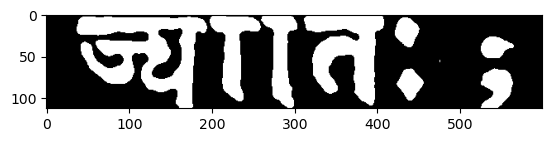

In [88]:
morp2 = morp[left_limit:right_limit+1]
plt.imshow(morp2, cmap='gray');

In [89]:
im = morp2.copy()
    
horizontal_hist = np.sum(im, axis=0, keepdims=True)/255
v=horizontal_hist.flatten()

df = pd.DataFrame(v)
df = df.T
df

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

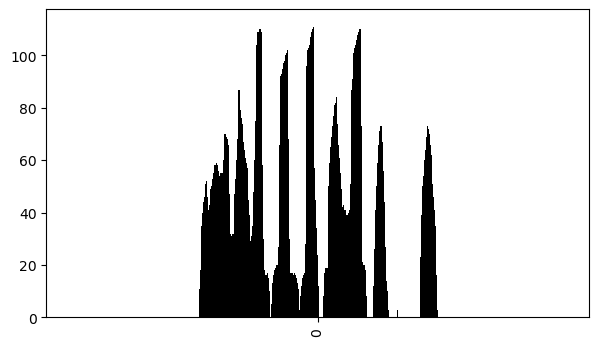

In [90]:
df.plot(kind='bar', color='k', legend=False, figsize=(7,4))

In [91]:
check_left = []
check_right = []
pix_thresh = 3
width = 3
def strt(stat_index, arr):
    #print('starting with index:', stat_index)
    
    #finding start
    for i in range(stat_index, len(arr)):
        
        if arr[i] > pix_thresh:
            ##print('a > {}: {}'.format(pix_thresh, i))

            # finding the end
            for j in range(i+1,len(arr)):  # if i is >= len(arr) then this won't execute
                #print('j check:', j)
                if arr[j] < pix_thresh:
                    ##print('b < {}: {}'.format(pix_thresh, j))

                    # width check
                    if j - i > width:
                        #print('saving')
                        #saving if width is fine
                        check_left.append(i)
                        check_right.append(j)

                        # if we have reached the end, then exit
                        if i == len(arr)-1 or j == len(arr)-1:
                            #print('1st tick')
                            return
                            
                        # find a new start from after the pixel
                        else:
                            j = j+1
                            strt(j, arr) 
                            return

                    elif i == len(arr)-1 or j == len(arr)-1:
                            #print('2nd tick')
                            return
                        
                    else:
                        #print('Width is too less')
                        strt(j,arr)  # should be one elif
                        return
                
                
                #print('pixel', i, j) 
                if i == len(arr)-1 or j == len(arr)-1:
                    #print('3rd tick')
                    return
                
strt(0,v)
pairs = list(zip(check_left, check_right))
print(len(pairs), len(check_left), len(check_right))

6 6 6


In [92]:
pairs

[(37, 195), (198, 260), (261, 304), (312, 409), (422, 457), (526, 566)]

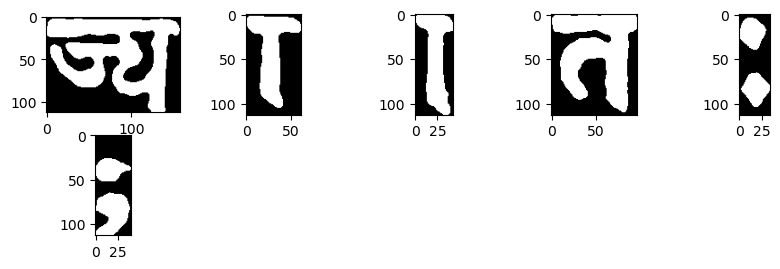

In [93]:
plt.figure(figsize=(10,6))
for i in range(len(pairs)):
    plt.subplot(4,5,i+1)
    plt.imshow(morp2[:, pairs[i][0]:pairs[i][1]], cmap='gray')

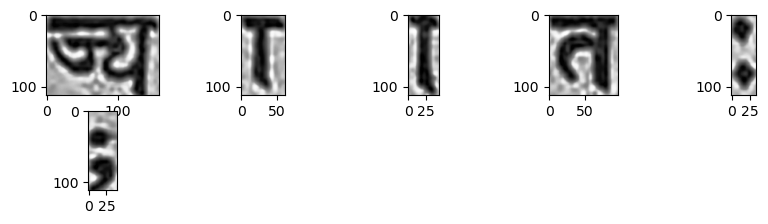

In [94]:

morp3 = gray[left_limit:right_limit]

plt.figure(figsize=(10,6))
for i in range(len(pairs)):
    plt.subplot(5,5,i+1)
    plt.imshow(morp3[:, pairs[i][0]:pairs[i][1]], cmap='gray')